In [3]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
import pickle
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def load_data():
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.boston_housing.load_data(
        path="boston_housing.npz", test_split=0.2, seed=113
    )

    mean = x_train.mean(axis=0)
    std = x_train.std(axis=0)
    x_train = (x_train - mean) / std
    x_test = (x_test - mean) / std

    return (x_train, y_train), (x_test, y_test), mean, std


In [4]:
def build_model(input_shape):
    model = Sequential([
        Dense(64, activation='relu', input_shape=(input_shape,)),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1)
    ])

    model.compile(optimizer=Adam(learning_rate=0.001),
                 loss='mse',
                 metrics=['mae'])

    return model

def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    return {
        'mae': mae,
        'mse': mse,
        'rmse': rmse,
        'r2': r2,
        'accuracy_percentage': r2 * 100
    }


In [7]:
def train_model(epochs=100, batch_size=32):

    (x_train, y_train), (x_test, y_test), mean, std = load_data()

    model = build_model(x_train.shape[1])

    early_stop = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=20, restore_best_weights=True)

    history = model.fit(
        x_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=0.2,
        callbacks=[early_stop],
        verbose=1
    )
    return model, history, x_train, y_train, x_test, y_test, mean, std

model, history, x_train, y_train, x_test, y_test, mean, std = train_model()

y_train_pred = model.predict(x_train).flatten()
y_test_pred = model.predict(x_test).flatten()

train_metrics = calculate_metrics(y_train, y_train_pred)
test_metrics = calculate_metrics(y_test, y_test_pred)

print("\n===== Model Evaluation =====")
print("\nTraining Data Metrics:")
print(f"MAE: {train_metrics['mae']:.4f}")
print(f"MSE: {train_metrics['mse']:.4f}")
print(f"RMSE: {train_metrics['rmse']:.4f}")
print(f"R²: {train_metrics['r2']:.4f}")
print(f"Accuracy (R² as %): {train_metrics['accuracy_percentage']:.2f}%")

print("\nTest Data Metrics:")
print(f"MAE: {test_metrics['mae']:.4f}")
print(f"MSE: {test_metrics['mse']:.4f}")
print(f"RMSE: {test_metrics['rmse']:.4f}")
print(f"R²: {test_metrics['r2']:.4f}")
print(f"Accuracy (R² as %): {test_metrics['accuracy_percentage']:.2f}%")

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 577.2617 - mae: 22.1825 - val_loss: 606.7317 - val_mae: 22.9166
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 485.2295 - mae: 20.3291 - val_loss: 558.8729 - val_mae: 21.8609
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 490.8466 - mae: 20.2067 - val_loss: 497.0205 - val_mae: 20.4367
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 424.7544 - mae: 18.5885 - val_loss: 416.3017 - val_mae: 18.4188
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 334.7515 - mae: 16.4251 - val_loss: 316.1188 - val_mae: 15.6316
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 252.5733 - mae: 13.7920 - val_loss: 212.1166 - val_mae: 12.0307
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 149.3273 - mae: 10.0958 - val_loss: 133.5273 - val_mae: 9.0473
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 98.8325 - mae: 8.1106 - val_loss: 95.1293 - val_mae: 7.6233
Epoch 9/100
11/11 ━━━━━━━━━

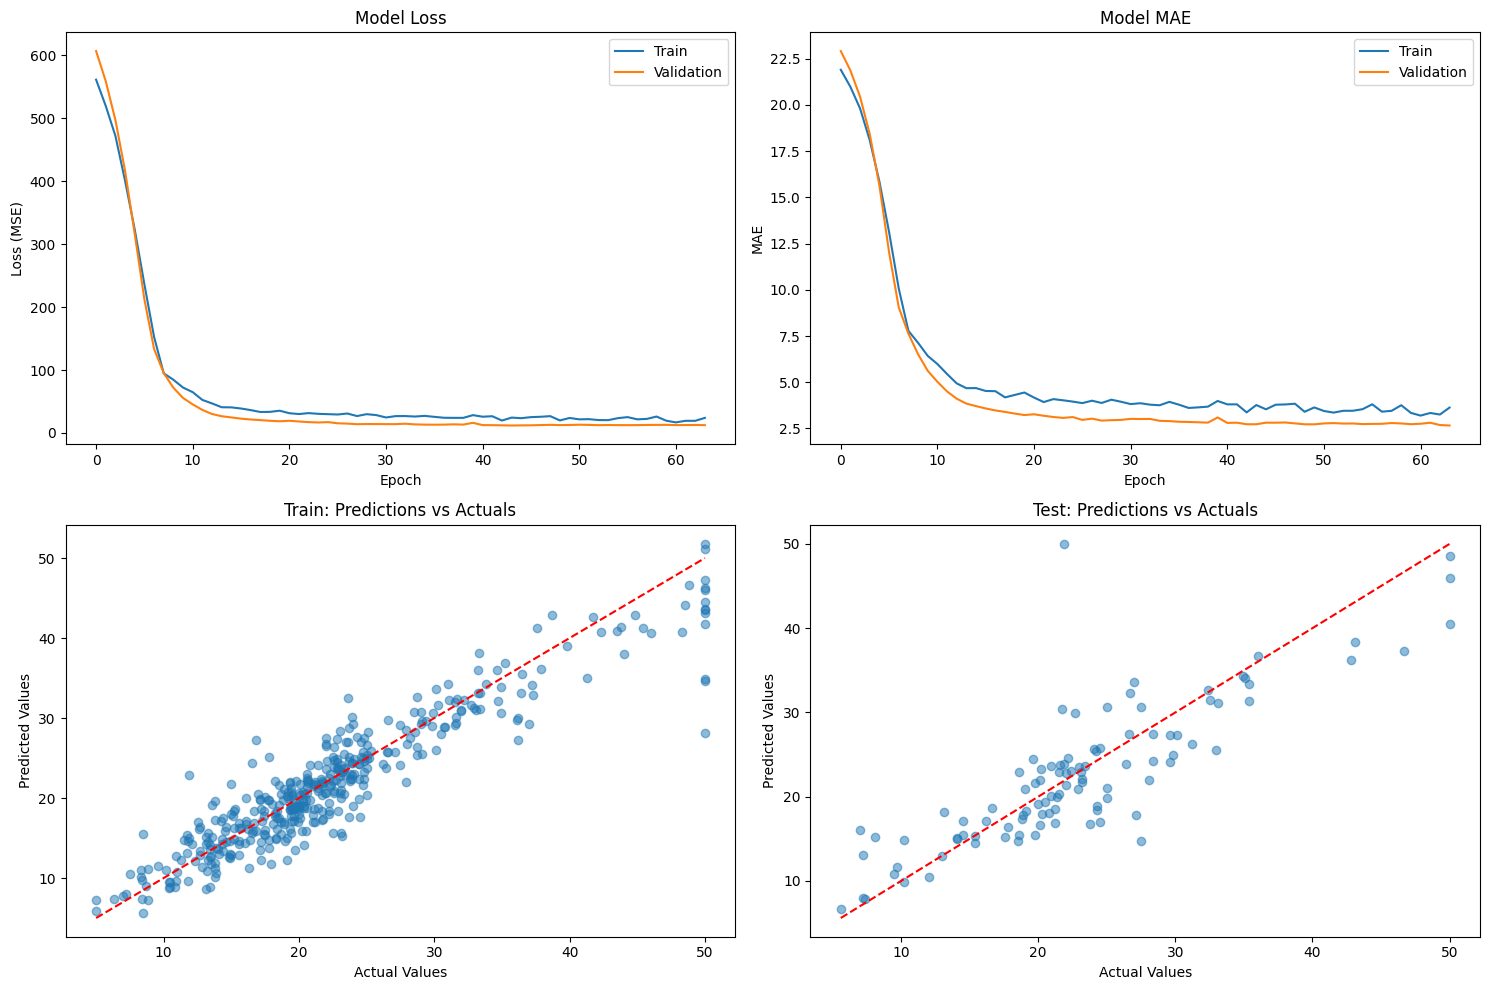

In [8]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.subplot(2, 2, 2)
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.subplot(2, 2, 3)
plt.scatter(y_train, y_train_pred, alpha=0.5)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Train: Predictions vs Actuals')

plt.subplot(2, 2, 4)
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Test: Predictions vs Actuals')

plt.tight_layout()
plt.savefig('training_history.png')

model.save('housing_regression_model.h5')

params = {
    'mean': mean,
    'std': std,
    'train_metrics': train_metrics,
    'test_metrics': test_metrics
}

with open('model_params.pkl', 'wb') as f:
    pickle.dump(params, f)

In [10]:
if __name__ == "__main__":
    model, mean, std, train_metrics, test_metrics = train_model()
    print("\nModel trained and saved as 'housing_regression_model.h5'")
    print(f"Final model accuracy: {test_metrics['accuracy_percentage']:.2f}%")

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 514.4212 - mae: 20.8239 - val_loss: 576.6954 - val_mae: 22.1658
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 477.3531 - mae: 19.9341 - val_loss: 517.1791 - val_mae: 20.8294
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 416.2173 - mae: 18.3048 - val_loss: 433.2098 - val_mae: 18.8723
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 375.6514 - mae: 17.0719 - val_loss: 321.3915 - val_mae: 15.9109
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 265.0361 - mae: 13.7163 - val_loss: 204.8835 - val_mae: 12.0807
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 169.0007 - mae: 10.8282 - val_loss: 117.6868 - val_mae: 8.5772
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 110.6116 - mae: 8.7010 - val_loss: 84.1127 - val_mae: 7.4681
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 87.2821 - mae: 7.4816 - val_loss: 65.8540 - val_mae: 6.6349
Epoch 9/100
11/11 ━━━━━━━━━━

ValueError: too many values to unpack (expected 5)

In [12]:
if __name__ == "__main__":
    model, history, x_train, y_train, x_test, y_test, mean, std = train_model()

    y_train_pred = model.predict(x_train).flatten()
    y_test_pred = model.predict(x_test).flatten()

    train_metrics = calculate_metrics(y_train, y_train_pred)
    test_metrics = calculate_metrics(y_test, y_test_pred)

    print("\n 'housing_regression_model.h5'")
    print(f"Final model accuracy: {test_metrics['accuracy_percentage']:.2f}%")

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 556.8677 - mae: 21.8507 - val_loss: 620.2547 - val_mae: 23.1155
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 525.3546 - mae: 21.1457 - val_loss: 594.0525 - val_mae: 22.5311
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 530.0464 - mae: 20.8715 - val_loss: 555.4786 - val_mae: 21.6370
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 442.2394 - mae: 19.0101 - val_loss: 498.4067 - val_mae: 20.2334
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 371.7376 - mae: 17.3190 - val_loss: 416.8144 - val_mae: 18.1147
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 319.5450 - mae: 15.3716 - val_loss: 311.1188 - val_mae: 15.1511
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 221.3995 - mae: 12.3748 - val_loss: 199.0554 - val_mae: 11.6234
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 144.9620 - mae: 9.6226 - val_loss: 119.2760 - val_mae: 8.3614
Epoch 9/100
11/11 ━━━━━━━